In [ ]:
# This notebook is to make Figure 1 of Rodgers et al. 2021 (https://doi.org/10.5194/esd-2021-50). 
# If you have have any questions, please contact the author of this notebook.
# Author: Ryohei Yamaguchi (ryamaguchi  at  pusan.ac.kr)

In [1]:
## The mpirun command:
## mpirun --np 6 dask-mpi --scheduler-file scheduler.json --no-nanny --dashboard-address :8785 --memory-limit=60e9from dask.distributed import Client
client = Client(scheduler_file='/proj/ryamaguchi/Dask/run_2/scheduler.json')
client

Client Scheduler: tcp://203.247.189.225:33460 Dashboard: http://203.247.189.225:8786/status,Cluster Workers: 8 Cores: 144 Memory: 480.00 GB


### Import

In [2]:
%matplotlib inline

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import glob
import os 

from datetime import datetime
today = datetime.today()

import pop_tools
pop_grid = pop_tools.get_grid('POP_gx1v7')

from tqdm.notebook import tqdm_notebook

/home/ryamaguchi/.conda/envs/geoview/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10005. The TBB threading layer is disabled.
  warnings.warn(problem)


### Read 

In [3]:
VAR = ['TEMP','RHO','MOC','photoC_TOT_zint','FG_CO2',
       'aice_d']

scenarios=('HIST','SSP370')
members_cmip=('1001.001','1021.002','1041.003','1061.004','1081.005','1101.006','1121.007','1141.008','1161.009','1181.010',
              '1231.001','1231.002','1231.003','1231.004','1231.005','1231.006','1231.007','1231.008','1231.009','1231.010',
              '1251.001','1251.002','1251.003','1251.004','1251.005','1251.006','1251.007','1251.008','1251.009','1251.010',
              '1281.001','1281.002','1281.003','1281.004','1281.005','1281.006','1281.007','1281.008','1281.009','1281.010',
              '1301.001','1301.002','1301.003','1301.004','1301.005','1301.006','1301.007','1301.008','1301.009','1301.010')
members_smbb=('1011.001','1031.002','1051.003','1071.004','1091.005','1111.006','1131.007','1151.008','1171.009','1191.010',
              '1231.011','1231.012','1231.013','1231.014','1231.015','1231.016','1231.017','1231.018','1231.019','1231.020',
              '1251.011','1251.012','1251.013','1251.014','1251.015','1251.016','1251.017','1251.018','1251.019','1251.020',
              '1281.011','1281.012','1281.013','1281.014','1281.015','1281.016','1281.017','1281.018','1281.019','1281.020',
              '1301.011','1301.012','1301.013','1301.014','1301.015','1301.016','1301.017','1301.018','1301.019','1301.020')
members=members_cmip+members_smbb
ensembles = [ens for ens in range(len(members))]

In [4]:
exceptcv=['time','nlon','nlat','transport_reg','moc_comp','moc_z','z_t','lat_aux_grid','transport_regions','moc_components','dz',*VAR]
def process_coords(ds, drop=True, except_coord_vars=exceptcv):
    """Preprocessor function to drop all non-dim coords, which slows down concatenation."""
    coord_vars = []
    for v in np.array(ds.coords) :
        if not v in except_coord_vars:
            coord_vars += [v]
    for v in np.array(ds.data_vars) :
        if not v in except_coord_vars:
            coord_vars += [v]
          
    if drop:
        return ds.drop(coord_vars)
    else:
        return ds.set_coords(coord_vars)

In [5]:
file_list=[]
for var in VAR :
    ens_files=[]
    for member in members :
        files=[]    
        for scenario in scenarios :
            comp,model,time='ocn','pop.h','month_1'
            if var=='aice_d': comp,model,time='ice','cice.h1','day_1'

            in_dir = '/proj/jedwards/archive/b.e21.B'+scenario+'*.f09_g17.LE2-'+member+'/'+comp+'/proc/tseries/'+time+'/'
            
            fn = 'b.e21.B'+scenario+'*.f09_g17.LE2-'+member+'.'+model+'.'+var+'.*.nc'
            files += glob.glob(in_dir+fn)
            files = sorted(files)
        ens_files.append(files)
    file_list.append(ens_files) 


In [6]:
for i in range(len(VAR)):
    print(i,VAR[i],len(file_list[i][:]))

0 TEMP 100
1 RHO 100
2 MOC 100
3 photoC_TOT_zint 100
4 FG_CO2 100
5 aice_d 100


In [7]:
ds_0=xr.open_mfdataset(file_list[0],chunks={'time':1},combine='nested',concat_dim=[[*ensembles],'time'],parallel='True',
                       preprocess=process_coords,decode_cf=True,decode_times=True)
ds_1=xr.open_mfdataset(file_list[1],chunks={'time':1},combine='nested',concat_dim=[[*ensembles],'time'],parallel='True',
                       preprocess=process_coords,decode_cf=True,decode_times=True)
ds_2=xr.open_mfdataset(file_list[2],chunks={'time':120},combine='nested',concat_dim=[[*ensembles],'time'],parallel='True',
                       preprocess=process_coords,decode_cf=True,decode_times=True)
ds_3=xr.open_mfdataset(file_list[3],chunks={'time':12},combine='nested',concat_dim=[[*ensembles],'time'],parallel='True',
                       preprocess=process_coords,decode_cf=True,decode_times=True)
ds_4=xr.open_mfdataset(file_list[4],chunks={'time':12},combine='nested',concat_dim=[[*ensembles],'time'],parallel='True',
                       preprocess=process_coords,decode_cf=True,decode_times=True)
ds_5=xr.open_mfdataset(file_list[5],chunks={'time':12},combine='nested',concat_dim=[[*ensembles],'time'],parallel='True',
                       preprocess=process_coords,decode_cf=True,decode_times=True)

In [8]:
ds_5=ds_5.rename({'nj':'nlat','ni':'nlon'})

In [9]:
time_new=xr.cftime_range(start='1850',end='2101',freq='1M',calendar='noleap')
ds_0=ds_0.assign_coords(time=time_new)
ds_1=ds_1.assign_coords(time=time_new)
ds_2=ds_2.assign_coords(time=time_new)
ds_3=ds_3.assign_coords(time=time_new)
ds_4=ds_4.assign_coords(time=time_new)
time_new_d=xr.cftime_range(start='1850-01-01',end='2100-12-31',freq='1D',calendar='noleap')
ds_5=ds_5.assign_coords(time=time_new_d)

ds_0=ds_0.assign_coords(z_t=pop_grid.z_t)
ds_1=ds_1.assign_coords(z_t=pop_grid.z_t)

ds_0=ds_0.assign_coords(TLONG=pop_grid.TLONG)
ds_0=ds_0.assign_coords(TLAT =pop_grid.TLAT )
ds_1=ds_1.assign_coords(TLONG=pop_grid.TLONG)
ds_1=ds_1.assign_coords(TLAT =pop_grid.TLAT )
ds_3=ds_3.assign_coords(TLONG=pop_grid.TLONG)
ds_3=ds_3.assign_coords(TLAT =pop_grid.TLAT )
ds_4=ds_4.assign_coords(TLONG=pop_grid.TLONG)
ds_4=ds_4.assign_coords(TLAT =pop_grid.TLAT )
ds_5=ds_5.assign_coords(TLONG=pop_grid.TLONG)
ds_5=ds_5.assign_coords(TLAT =pop_grid.TLAT )
ds_3

,Array,Chunk
Bytes,346.98 MB,138.24 kB
Shape,"(3012, 100, 3)","(120, 1, 3)"
Count,15600 Tasks,2600 Chunks
Type,|S384,numpy.ndarray
,Array,Chunk
Bytes,231.32 MB,92.16 kB
Shape,"(3012, 100, 2)","(120, 1, 2)"
Count,15600 Tasks,2600 Chunks
Type,|S384,numpy.ndarray
,Array,Chunk


In [10]:
dz=(pop_grid.dz*1e-2).load() #cm -> m
dz

<xarray.DataArray 'dz' (z_t: 60)>
array([ 10.      ,  10.      ,  10.      ,  10.      ,  10.      ,
        10.      ,  10.      ,  10.      ,  10.      ,  10.      ,
        10.      ,  10.      ,  10.      ,  10.      ,  10.      ,
        10.      ,  10.196808,  10.564484,  11.059951,  11.67807 ,
        12.424133,  13.309678,  14.35141 ,  15.571259,  16.996796,
        18.662124,  20.609023,  22.888521,  25.562471,  28.70575 ,
        32.408372,  36.777725,  41.940308,  48.042236,  55.247544,
        63.731919,  73.669448,  85.208926,  98.436582, 113.324658,
       129.671992, 147.053438, 164.80709 , 182.091348, 198.022344,
       211.85957 , 223.165098, 231.864941, 238.194492, 242.572168,
       245.467793, 247.310137, 248.443281, 249.119746, 249.51291 ,
       249.735938, 249.859609, 249.926738, 249.962441, 249.981094])
Coordinates:
  * z_t      (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05

<xarray.DataArray 'TAREA' (nlat: 384, nlon: 320)>
array([[1.12478609e+09, 1.12464644e+09, 1.12436015e+09, ...,
        1.12436015e+09, 1.12464644e+09, 1.12478609e+09],
       [1.45745047e+09, 1.45745047e+09, 1.45745047e+09, ...,
        1.45745047e+09, 1.45745047e+09, 1.45745047e+09],
       [1.52530781e+09, 1.52530781e+09, 1.52530781e+09, ...,
        1.52530781e+09, 1.52530781e+09, 1.52530781e+09],
       ...,
       [8.81450970e+08, 8.81311214e+08, 8.81016095e+08, ...,
        8.81016095e+08, 8.81311214e+08, 8.81450970e+08],
       [8.13997430e+08, 8.13851312e+08, 8.13544719e+08, ...,
        8.13544719e+08, 8.13851312e+08, 8.13997430e+08],
       [7.43222977e+08, 7.43072723e+08, 7.42759165e+08, ...,
        7.42759165e+08, 7.43072723e+08, 7.43222977e+08]])
Dimensions without coordinates: nlat, nlon

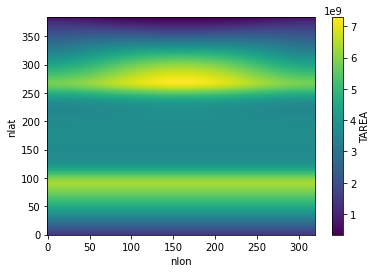

In [11]:
area=(pop_grid.TAREA*1e-4).load()  #cm2 -> m2
area.plot()
area

<xarray.DataArray (nlat: 384, nlon: 320, z_t: 60)>
array([[[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        ...,
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
...
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        ...,
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]]])
Coordinates:
  * z_t      (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
    TLONG    (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 318.9 319.4 319.8
    TLAT     (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
Dimensions without coordinates: nlat, nlon

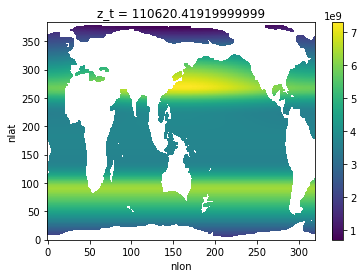

In [27]:
area_3d=(pop_grid.TAREA*1e-4*xr.where(np.isnan(ds_0.TEMP.isel(concat_dim=0,time=0).drop(('concat_dim','time'))),np.nan,1)).load()  #cm2 -> m2
area_3d.isel(z_t=40).plot()
area_3d

### Time series (ocn)

#### OHC 

In [12]:
cp = 3.996e3 #J/kg/K
sz,ez=0,46 #0-2000 m
print(ds_0.z_t.values[sz],ds_0.z_t.values[ez])
for i in tqdm_notebook(range(len(members))):
    ohc_t=(1e3*ds_1.RHO.isel(concat_dim=i,z_t=slice(sz,ez))*cp*(ds_0.TEMP.isel(concat_dim=i,z_t=slice(sz,ez))+273.15)*area*dz.isel(z_t=slice(sz,ez))).sum(('nlon','nlat','z_t'),skipna=True).load()
    if i==0 : ts_ohc=ohc_t
    if i!=0 : ts_ohc=xr.concat([ts_ohc,ohc_t],dim='concat_dim')

500.0 218645.65269999998


#### AMOC

In [13]:
### Maximum transport (200 - 6000 m depth)
ts_amoc=ds_2.MOC.isel(transport_reg=1).sum(dim='moc_comp').sel(moc_z=slice(20000.,600000.)).max(dim='moc_z').load()

#### NPP & CO2 flux

In [14]:
ts_npp = (ds_3[VAR[3]]*area).sum(('nlon','nlat'),skipna=True).load()  #mmol m-3 cm s-1 -> mmol m-1 cm s-1
ts_co2 = (ds_4[VAR[4]]*area).sum(('nlon','nlat'),skipna=True).load()  #mmol m-3 cm s-1 -> mmol m-1 cm s-1

### Time series (ice)

In [15]:
### Sum of gird-area where aice>=0.15

for i in tqdm_notebook(range(len(members))):
    ts_ice_nh_t = (xr.where(ds_5.aice_d.isel(concat_dim=i)>=0.15,1,np.nan)*area).where(ds_5.TLAT>40.).sum(('nlon','nlat'),skipna=True).load()
    if i==0 : ts_ice_nh=ts_ice_nh_t
    if i!=0 : ts_ice_nh=xr.concat([ts_ice_nh,ts_ice_nh_t],dim='concat_dim')     

    ts_ice_sh_t = (xr.where(ds_5.aice_d.isel(concat_dim=i)>=0.15,1,np.nan)*area).where(ds_5.TLAT<-40.).sum(('nlon','nlat'),skipna=True).load()
    if i==0 : ts_ice_sh=ts_ice_sh_t
    if i!=0 : ts_ice_sh=xr.concat([ts_ice_sh,ts_ice_sh_t],dim='concat_dim')     

In [16]:
ts_ice_nh_mon = ts_ice_nh.resample(time='1M').mean()
ts_ice_sh_mon = ts_ice_sh.resample(time='1M').mean()

### Write

In [22]:
paths=[]
var=['OHC2000','AMOC','photoC_TOT_zint','FG_CO2','aice_d','aice_d']
region=['global','','global','global','NH','SH']
ln=['Global ocean heat content (0-2000 m)','Max. AMOC transport','Global-integrated photC_TOT_zint',
    'Global-integrated CO2 uptake','NH sea ice extent','SH sea ice extent']
unit=['J','Sverdrups','mmol m-1 cm s-1','mmol m-1 cm s-1','m2','m2']


for i in range(6):
    if i==0 : da_w=ts_ohc
    if i==1 : da_w=ts_amoc
    if i==2 : da_w=ts_npp
    if i==3 : da_w=ts_co2
    if i==4 : da_w=ts_ice_nh_mon
    if i==5 : da_w=ts_ice_sh_mon

    vname=var[i]
    out_dir='/proj/ryamaguchi/CESM2_LENS/time.series/'
    fn=today.strftime("%y%m%d")+'_'+region[i]+'.'+var[i]+'.%s-members.nc' %len(members)

    da_w.name=vname
    ds_w=da_w.to_dataset()
    ds_w=ds_w.rename({'concat_dim':'ensemble'})
    ds_w=ds_w.assign_coords(ensemble=[*members])
    ds_w[vname].attrs['units']        = unit[i]
    ds_w[vname].attrs['long_name']    =  ln[i]
#    ds_w[vname].attrs['_FillValue']   = ds[VAR[i]].encoding['_FillValue']
#    ds_w[vname].attrs['missing_value']= ds[VAR[i]].encoding['missing_value']
    ds_w.attrs['history']="%s members, script path: %s, made by ryamaguchi" %(len(members),os.getcwd())

    ds_w.to_netcdf(path=out_dir+fn, mode="w",format="NETCDF4_CLASSIC" )
    paths+=[out_dir+fn]